In [1]:
# Install 
#!pip install transformers gradio sentencepiece numpy torch torchvision trdg Pillow==9.5.0

# Core Python Data Science and Image Processing Libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Deep Learning and Model Specific Libraries
import torch
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Utility and Interface Libraries
import gradio as gr
from IPython.display import IFrame
from trdg.generators import GeneratorFromStrings


Missing modules for handwritten text generation.


In [2]:
# @title Plotting functions

def display_image(image_path):
    """Display an image from a given file path.

    Args:
        image_path (str): The path to the image file.
    """
    # Open the image
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()

def display_transformed_images(image, transformations):
    """
    Apply a list of transformations to an image and display them.

    Args:
        image (Tensor): The input image as a tensor.
        transformations (list): A list of torchvision transformations to apply.
    """
    # Convert tensor image to PIL Image for display
    pil_image = transforms.ToPILImage()(image)

    fig, axs = plt.subplots(len(transformations) + 1, 1, figsize=(5, 15))
    axs[0].imshow(pil_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    for i, transform in enumerate(transformations):
        # Apply transformation if it's not the placeholder
        if transform != "Custom ElasticTransform Placeholder":
            transformed_image = transform(image)
            # Convert transformed tensor image to PIL Image for display
            display_image = transforms.ToPILImage()(transformed_image)
            axs[i+1].imshow(display_image)
            axs[i+1].set_title(transform.__class__.__name__)
            axs[i+1].axis('off')
        else:
            axs[i+1].text(0.5, 0.5, 'ElasticTransform Placeholder', ha='center')
            axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_original_and_transformed_images(original_tensor, transformed_tensor):
    """
    Display the original and transformed images side by side.

    Args:
        original_tensor (Tensor): The original image as a tensor.
        transformed_tensor (Tensor): The transformed image as a tensor.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    original_image = original_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[0].imshow(original_image)
    axs[0].set_title('Original')
    axs[0].axis('off')

    # Display transformed image
    transformed_image = transformed_tensor.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    axs[1].imshow(transformed_image)
    axs[1].set_title('Transformed')
    axs[1].axis('off')

    plt.show()

def display_generated_images(generator):
    """
    Display images generated from strings.

    Args:
        generator (GeneratorFromStrings): A generator that produces images from strings.
    """
    plt.figure(figsize=(15, 3))
    for i, (text_img, lbl) in enumerate(generator, 1):
        ax = plt.subplot(1, len(generator.strings) * generator.count // len(generator.strings), i)
        plt.imshow(text_img)
        plt.title(f"Example {i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [3]:
# Load the pre-trained TrOCR model and processor
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

# Define the function to recognize text from an image
def recognize_text(image):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

# Create a Gradio interface
interface = gr.Interface(
    fn=recognize_text,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="Interactive demo: TrOCR",
    description="Demo for Microsoft’s TrOCR, an encoder-decoder model for OCR on single-text line images.",
)

# Launch the interface
interface.launch()


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [4]:
# Load the model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Inspect the encoder of the model
model.encoder


DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0): DeiTLayer(
        (attention): DeiTAttention(
          (attention): DeiTSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUActivation

In [6]:
# Inspect the decoder of the model
model.decoder

TrOCRForCausalLM(
  (model): TrOCRDecoderWrapper(
    (decoder): TrOCRDecoder(
      (embed_tokens): Embedding(64044, 256, padding_idx=1)
      (embed_positions): TrOCRLearnedPositionalEmbedding(514, 256)
      (layernorm_embedding): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0): TrOCRDecoderLayer(
          (self_attn): TrOCRAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): TrOCRAttention(
            (k_proj): Linear(in_features=384, out_features=256, bias=True)
            (v_proj): Linear(in_features=384, out_features=2

In [7]:
# Function to count the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Count parameters in the encoder
encoder_params = count_parameters(model.encoder)

# Count parameters in the decoder
decoder_params = count_parameters(model.decoder)

encoder_params, decoder_params

(21960192, 39636480)

In [8]:
def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Parameters:
    - total_words: total number of words to be written.
    - words_per_day: number of words written per day.
    - days_per_week: number of days dedicated to writing per week.
    - weeks_per_year: number of weeks dedicated to writing per year.
    - average_human_lifespan: average lifespan of a human in years.

    Returns:
    - time_to_write_lifetimes: time to write the given words in lifetimes.
    """

    #################################################
    ## TODO for students: fill in the missing variables ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################
    
    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / ... 

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words, 
    #words_per_day, 
    #days_per_week, 
    #weeks_per_year, 
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")


In [9]:
# to_remove solution
def calculate_writing_time(total_words, words_per_day, days_per_week, weeks_per_year, average_human_lifespan):
    """
    Calculate the time required to write a given number of words in lifetimes.

    Parameters:
    - total_words: total number of words to be written.
    - words_per_day: number of words written per day.
    - days_per_week: number of days dedicated to writing per week.
    - weeks_per_year: number of weeks dedicated to writing per year.
    - average_human_lifespan: average lifespan of a human in years.

    Returns:
    - time_to_write_lifetimes: time to write the given words in lifetimes.
    """
    
    words_per_year = words_per_day * days_per_week * weeks_per_year

    # Calculate the time to write in years
    time_to_write_years = total_words / words_per_year 

    # Calculate the time to write in lifetimes
    time_to_write_lifetimes = time_to_write_years / average_human_lifespan

    return time_to_write_lifetimes

# Example values
total_words = 5e9
words_per_day = 1500
days_per_week = 6
weeks_per_year = 50
average_human_lifespan = 80

# Uncomment the code below to test your function

# Test the function
#time_to_write_lifetimes_roberta = calculate_writing_time(
    #total_words, 
    #words_per_day, 
    #days_per_week, 
    #weeks_per_year, 
    #average_human_lifespan
#)

# Print the result
#print(f"Time to write {total_words} words in lifetimes: {time_to_write_lifetimes_roberta} lifetimes")


In [10]:
#Exploring Llama 2
total_tokens_llama2 = 2e12
total_words_llama2 = 2e12 / 1.5 #assuming 1.5 words per token

In [11]:
# Time to generate text
time_to_write_lifetimes_llama = calculate_writing_time(total_words_llama2, words_per_day, days_per_week, weeks_per_year, average_human_lifespan)

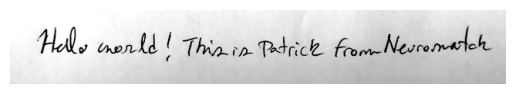

In [12]:
# Usage
image_path = '../static/img_1235.jpg'
display_image(image_path)

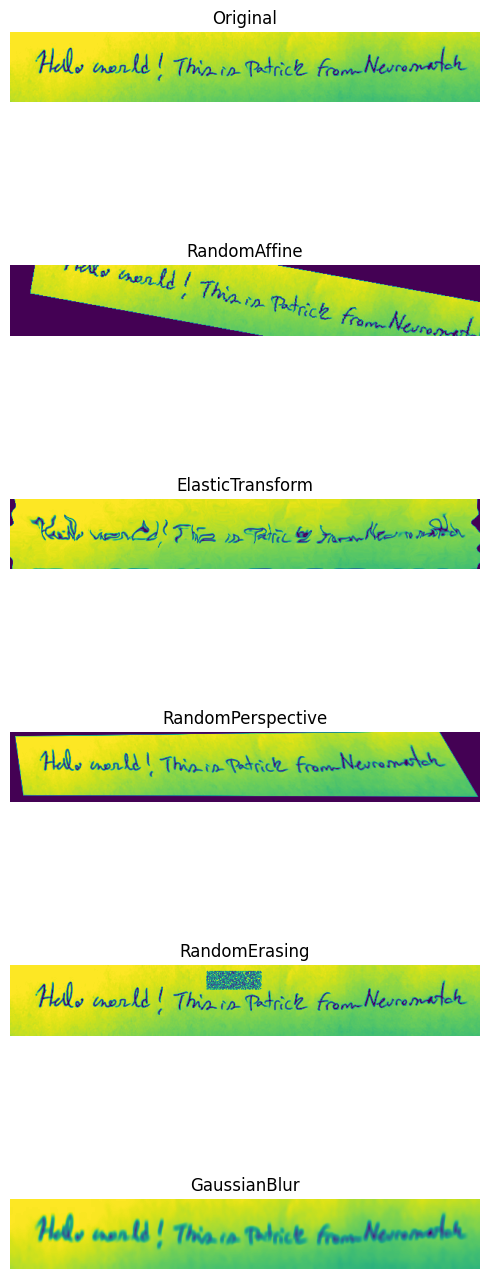

In [13]:
# Convert PIL Image to Tensor
image = Image.open(image_path)
image = transforms.ToTensor()(image)

# Define each transformation separately
# RandomAffine: applies rotations, translations, scaling. Here, rotates by up to ±15 degrees,
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))

# ElasticTransform: applies elastic distortions to the image. The 'alpha' parameter controls
# the intensity of the distortion.
elastic = transforms.ElasticTransform(alpha=50.0)

# RandomPerspective: applies random perspective transformations with a specified distortion scale.
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)

# RandomErasing: randomly erases a rectangle area in the image.
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)

# GaussianBlur: applies gaussian blur with specified kernel size and sigma range. 
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.4, 5))

# A list of all transformations for iteration
transformations = [affine, elastic, perspective, erasing, gaussian_blur]

display_transformed_images(image, transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


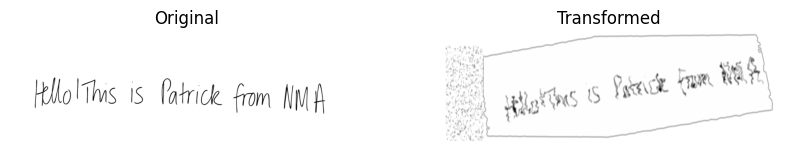

In [14]:
# Path to the image
image_path = '../static/image_augmentation.png'

# Open the image
image = Image.open(image_path)

# Convert PIL Image to Tensor
image_tensor = transforms.ToTensor()(image)

# Define your transformations here
affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
elastic = transforms.ElasticTransform(alpha=90.0)
perspective = transforms.RandomPerspective(distortion_scale=0.2, p=1.0)
erasing = transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False)
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

# Combine all the transformations
all_transforms = transforms.Compose([
    affine,
    elastic,
    perspective,
    erasing,
    gaussian_blur
])

# Apply combined transformation
augmented_image_tensor = all_transforms(image_tensor)

# Assuming 'image_tensor' and 'augmented_image_tensor' are defined as in your snippet
display_original_and_transformed_images(image_tensor, augmented_image_tensor)


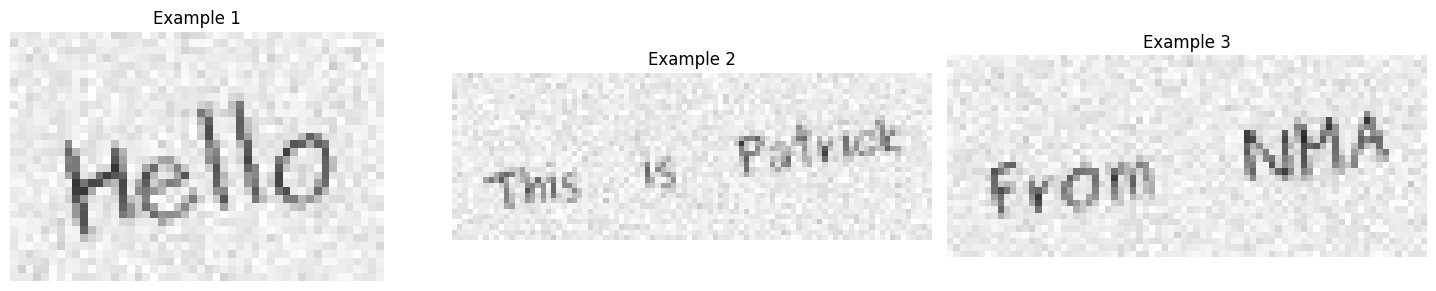

In [15]:
# Define your strings
strings = ['Hello', 'This is Patrick', 'From NMA']  # Update this list as needed

# Create a generator with the specified font
generator = GeneratorFromStrings(
    strings,
    space_width=2,
    skewing_angle=8,
    count=3,  # number of images to generate
    fonts=['Purisa']  # Update or add more fonts as needed
)

# Call the function with your generator
display_generated_images(generator)

In [16]:
IFrame("https://www.calligrapher.ai/", width=800, height=600)